In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join("..")))

In [2]:
import ee
import geemap
from utils import ee_utils, date_utils, plot_config

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Dict, List, Tuple

import warnings
warnings.filterwarnings("ignore")

In [3]:
from filter_nutzungsflaechen import (
    get_crops_to_exclude,
    get_rainfed_reference_crops,
    create_crop_filters,
    filter_crops,
    add_double_cropping_info,
)

In [4]:
ee.Initialize(project="thurgau-irrigation")

## Validating ET Blue Maps with Walter Koch's Estimates

This notebook follows a three-step process:

1. **Create Yearly ET Blue Maps (2018-2022):**  
   - Aggregate dekadal ET Blue maps into monthly maps.
   - Filter the maps to include only the growing season months (April through October).
   - Sum the monthly ET Blue maps to produce yearly ET Blue maps.

2. **Calculate Yearly ET Blue Values for Potentially Irrigated Fields:**  
   - Compute ET blue in m3/ha/yr for each crop field for each year.

3. **Compare ET Blue Values with Walter Koch's Estimates:**
   - Make pretty plots

## Aggregate dekadal ET Blue maps into monthly maps

In [5]:
ET_blue_collection = ee.ImageCollection("projects/thurgau-irrigation/assets/Thurgau/ET_blue_raw_2018-2022")

def back_to_float(image: ee.Image): 
    date = image.get("system:time_start")
    return image.toFloat().divide(100).set("system:time_start", date)

ET_blue_collection = ET_blue_collection.map(back_to_float)

In [6]:
# date_utils.print_collection_dates(ET_blue_collection)

In [7]:
# ET_blue_collection_monthly = ee_utils.aggregate_to_monthly(
#     ET_blue_collection, bands=["ET_blue", "ET_blue_m3"]
# )

## Filter the maps to include only the growing season months (April through October).

In [8]:
# ET_blue_collection_monthly_growing_season = ET_blue_collection_monthly.filter(ee.Filter.calendarRange(4, 10, "month"))

# date_utils.print_collection_dates(ET_blue_collection_monthly_growing_season)

## Sum the monthly ET Blue maps to produce yearly ET Blue maps.

In [9]:
def create_growing_season_yearly_sums(
    collection: ee.ImageCollection,
) -> ee.ImageCollection:
    """
    Create yearly sums from a collection of monthly images for the growing season (April to October).

    Args:
        collection (ee.ImageCollection): Input collection with monthly images for the growing season.

    Returns:
        ee.ImageCollection: Collection with yearly sum images for the growing season.
    """

    def sum_growing_season(year):
        start_date = ee.Date.fromYMD(year, 4, 1)  # April 1st
        end_date = ee.Date.fromYMD(year, 11, 1)  # November 1st (exclusive)
        yearly_sum = collection.filterDate(start_date, end_date).sum()
        return yearly_sum.set("year", year).set(
            "system:time_start", start_date.millis()
        )

    # Get the range of years in the collection
    start_year = ee.Date(collection.first().get("system:time_start")).get("year")
    end_year = ee.Date(
        collection.sort("system:time_start", False).first().get("system:time_start")
    ).get("year")

    # Create a list of years
    years = ee.List.sequence(start_year, end_year)

    # Map over the years to create yearly sums
    yearly_sums = ee.ImageCollection.fromImages(years.map(sum_growing_season))

    return yearly_sums


# ET_blue_collection_yearly = create_growing_season_yearly_sums(
#     ET_blue_collection_monthly_growing_season
# )

In [10]:
# ET_blue_collection_yearly.first().bandNames().getInfo()

## Compute ET blue in m3/ha/yr for each crop field for each year and export

In [11]:
def calculate_et_blue_per_field(
    et_blue_image: ee.Image, crop_fields: ee.FeatureCollection
) -> ee.FeatureCollection:
    """
    Calculate ET_blue in m3/ha/yr for each crop field and add it as a property.

    Args:
        et_blue_image (ee.Image): Image containing ET_blue estimates in m3/yr.
        crop_fields (ee.FeatureCollection): Collection of crop field features.

    Returns:
        ee.FeatureCollection: Updated crop fields with ET_blue_m3_ha_yr property.
    """

    def calculate_et_blue(feature: ee.Feature) -> ee.Feature:
        # Get the area of the feature in hectares
        area_ha = ee.Number(feature.get("Area (m^2)")).divide(10000)  # Convert m² to ha

        # Calculate the sum of ET_blue within the feature
        et_blue_sum = et_blue_image.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=feature.geometry(),
            scale=10,  # Use the resolution of the ET_blue image
            maxPixels=1e9,
        ).get("ET_blue_m3")

        # Calculate ET_blue in m3/ha/yr
        et_blue_m3_ha_yr = ee.Number(et_blue_sum).divide(area_ha).toInt()

        # Add the result as a new property
        return feature.set("ET_blue_m3_ha_yr", et_blue_m3_ha_yr)

    # Map the calculation over all features
    return crop_fields.map(calculate_et_blue)

In [12]:
def export_feature_collection(collection: ee.FeatureCollection, task_name: str, asset_id: str): 
    """
    Export the feature collection to an Earth Engine asset.

    Args:
        collection: The feature collection to export.
        year: The year of the feature collection.
        task_name: The name of the export task.
        asset_id: The asset ID to export to.
    """
    task = ee.batch.Export.table.toAsset(
        collection=collection,
        description=task_name,
        assetId=asset_id,
    )
    task.start()

In [13]:
# years = range(2020, 2023)

# not_irrigated_crops = get_crops_to_exclude()
# exclude_filter, _ = create_crop_filters(not_irrigated_crops, not_irrigated_crops)

# ET_blue_collection_yearly_list = ET_blue_collection_yearly.toList(
#     ET_blue_collection_yearly.size()
# )

# for year in years:
#     index = 2018 - year
#     nutzung_collection_year = ee.FeatureCollection(
#         f"projects/thurgau-irrigation/assets/Thurgau/Nutzungsflaechen/TG_{year}_area"
#     )

#     potentially_rainfed, _ = filter_crops(nutzung_collection_year, exclude_filter, _)

#     et_blue_image = ee.Image(ET_blue_collection_yearly_list.get(index))

#     crop_with_et_blue = calculate_et_blue_per_field(et_blue_image, potentially_rainfed)

#     task_name = f"ET_blue_m3_ha_yr_per_field_{year}"
#     asset_id = f"projects/thurgau-irrigation/assets/Thurgau/ET_blue_m3_ha_yr_per_field_2018-2022/{task_name}"

#     export_feature_collection(crop_with_et_blue, task_name, asset_id)
#     print(f"Exporting {task_name} to {asset_id}")

In [14]:

# nutzung_collection_year = ee.FeatureCollection(
#     f"projects/thurgau-irrigation/assets/Thurgau/Nutzungsflaechen/TG_{2020}_area"
# )



# potentially_rainfed, _ = filter_crops(nutzung_collection_year, exclude_filter, _)

# et_blue_image = ee.Image(ET_blue_collection_yearly_list.get(2))

# crop_with_et_blue = calculate_et_blue_per_field(et_blue_image, potentially_rainfed)

## Comparing to Walter Koch's estimates

In [15]:
irrigation_estimate = {
    "Einjährige Freilandgemüse, ohne Konservengemüse": [200, 1000],
    "Kartoffeln": [200, 1000],
    "Freiland-Konservengemüse": [200, 600],
}

IRRIGATION_EFFICIENCY = 0.5

In [16]:
def filter_dataframe(df: pd.DataFrame, crop_types: List[str]) -> pd.DataFrame:
    """
    Filter the DataFrame to include only the specified crop types.

    Args:
        df (pd.DataFrame): Input DataFrame with 'ET_blue_m3_ha_yr' and 'nutzung' columns.
        crop_types (List[str]): List of crop types to include.

    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    return df[df["nutzung"].isin(crop_types)]


def plot_histogram_comparison(
    calculated_et_blue: pd.DataFrame,
    farmer_estimates: Dict[str, Tuple[int, int]],
    output_destination: str,
) -> None:
    """
    Create a histogram comparison of calculated ET blue vs farmer estimates.

    Args:
        calculated_et_blue (pd.DataFrame): DataFrame with 'ET_blue_m3_ha_yr' and 'nutzung' columns.
        farmer_estimates (Dict[str, Tuple[int, int]]): Dictionary of farmer estimates for each crop type.
        output_destination (str): Output destination for the plot.
    """
    plot_config.set_plot_style()

    crop_types = list(farmer_estimates.keys())
    num_crops = len(crop_types)

    fig, axs = plt.subplots(1, num_crops, figsize=(6 * num_crops, 6))

    for i, crop in enumerate(crop_types):
        crop_data = calculated_et_blue[calculated_et_blue["nutzung"] == crop][
            "ET_blue_m3_ha_yr"
        ]

        sns.histplot(crop_data, kde=False, ax=axs[i])
        axs[i].axvline(
            farmer_estimates[crop][0],
            color="r",
            linestyle="--",
            label="Farmer's estimate range",
        )
        axs[i].axvline(farmer_estimates[crop][1], color="r", linestyle="--")

        axs[i].set_xlabel("ET Blue (m³/ha/yr)")
        axs[i].set_ylabel("Frequency")
        axs[i].set_title(f"{crop}")

        # Add summary statistics
        mean_value = crop_data.mean()
        median_value = crop_data.median()
        axs[i].axvline(
            mean_value, color="g", linestyle="-", label=f"Average: {mean_value:.0f}"
        )

        axs[i].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)

    plt.tight_layout()

    plt.savefig(output_destination, bbox_inches="tight", dpi=300)
    plt.subplots_adjust(bottom=0.2)

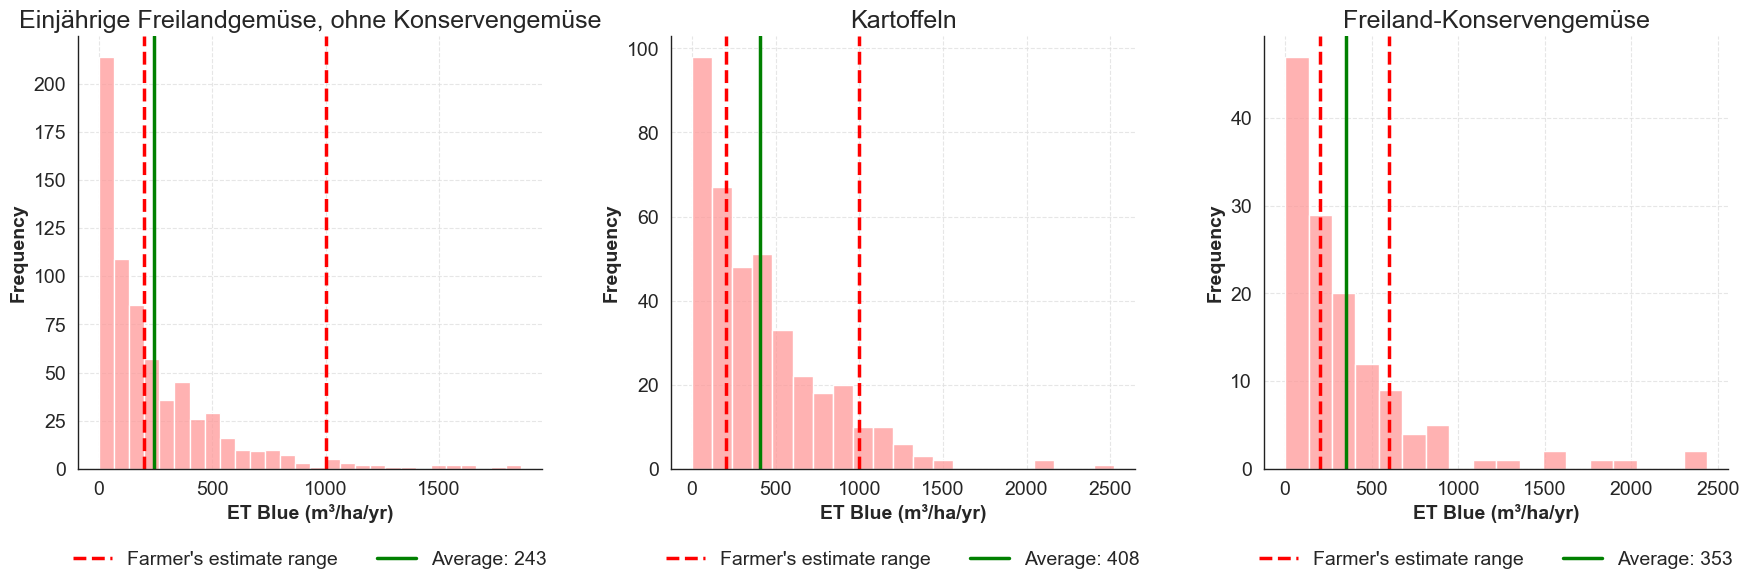

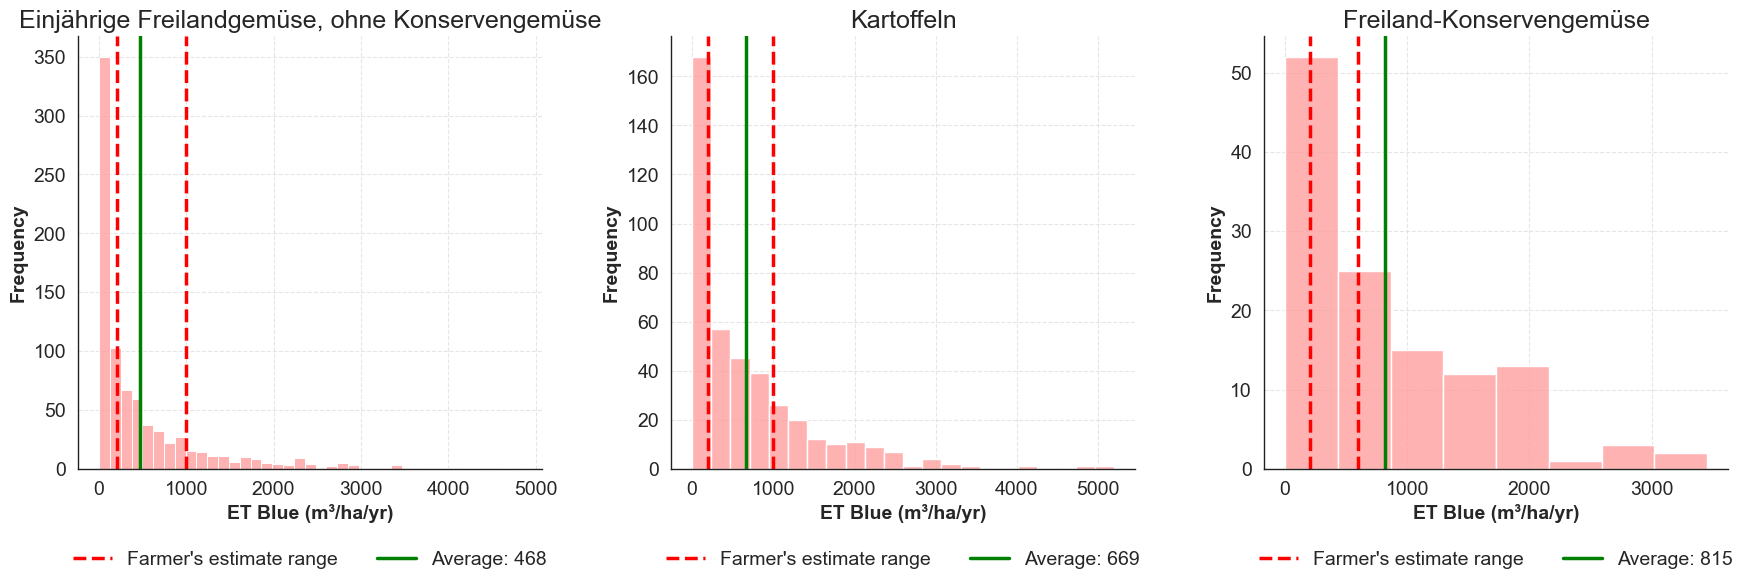

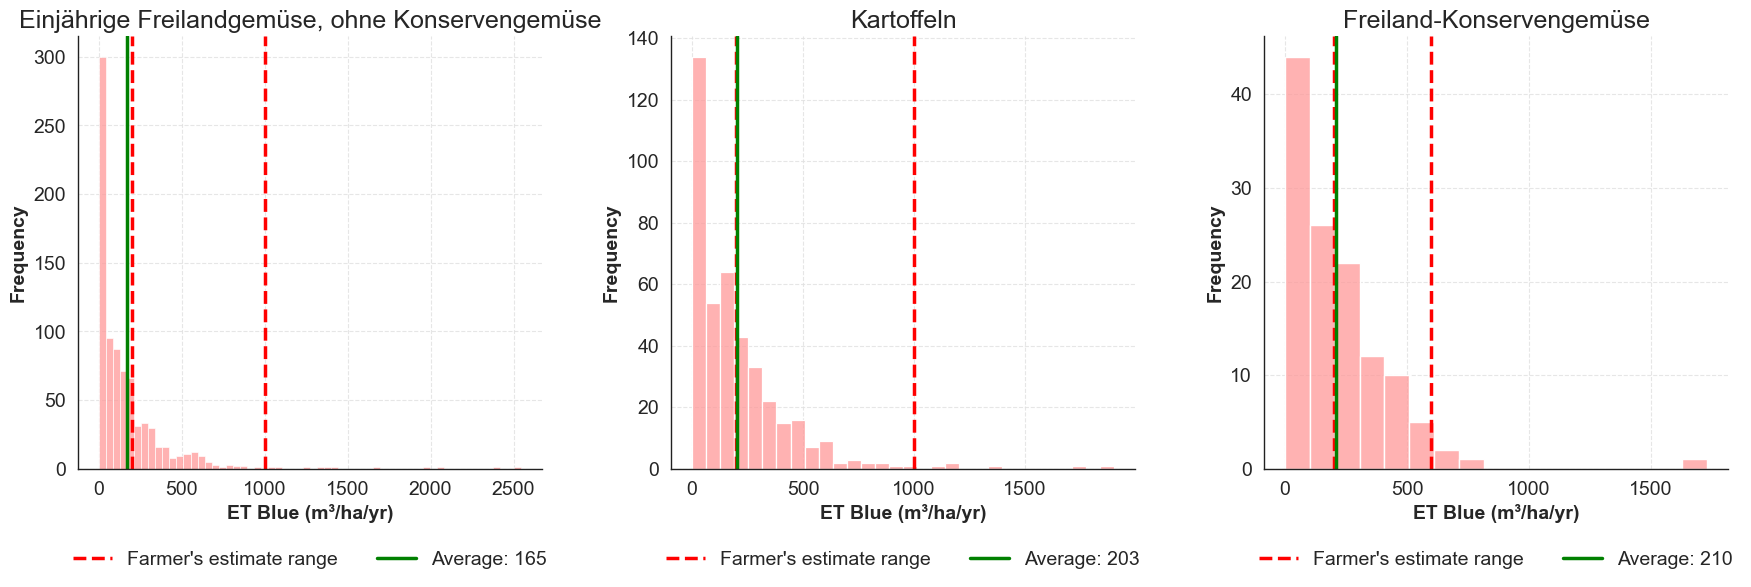

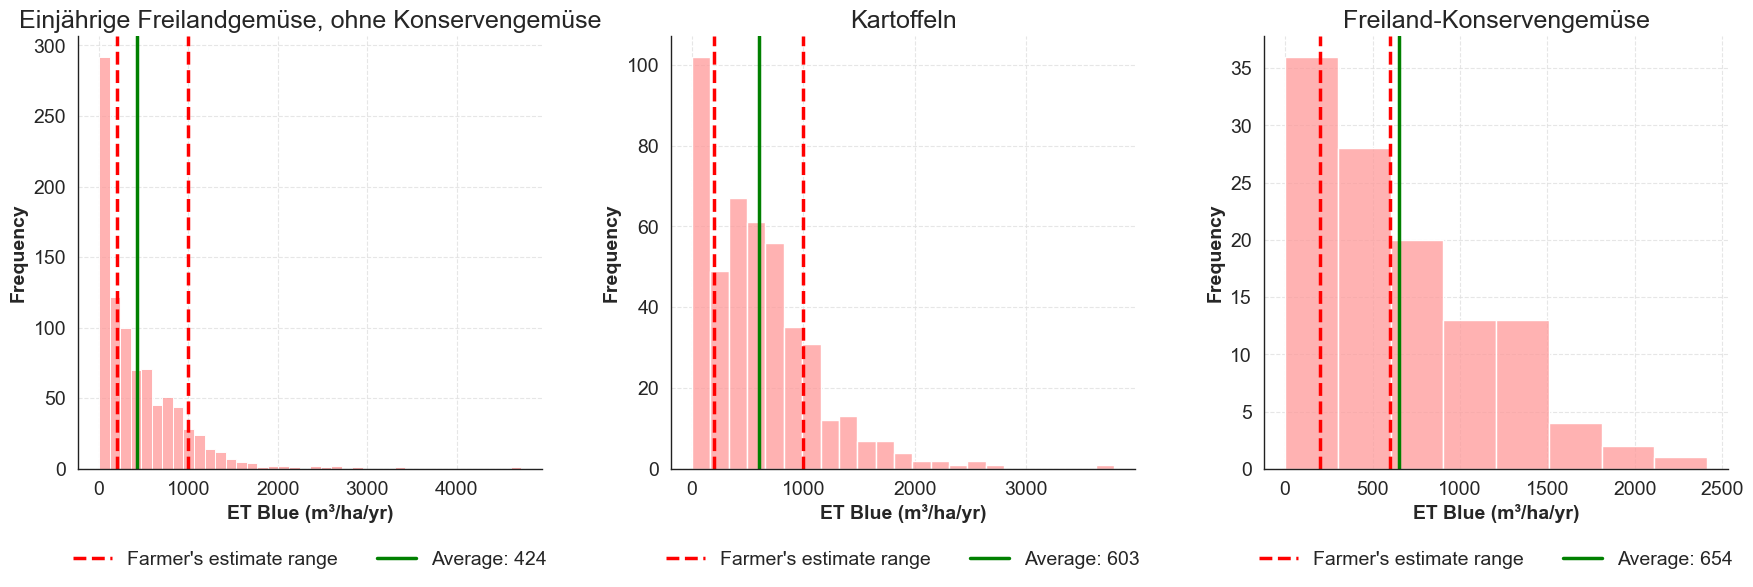

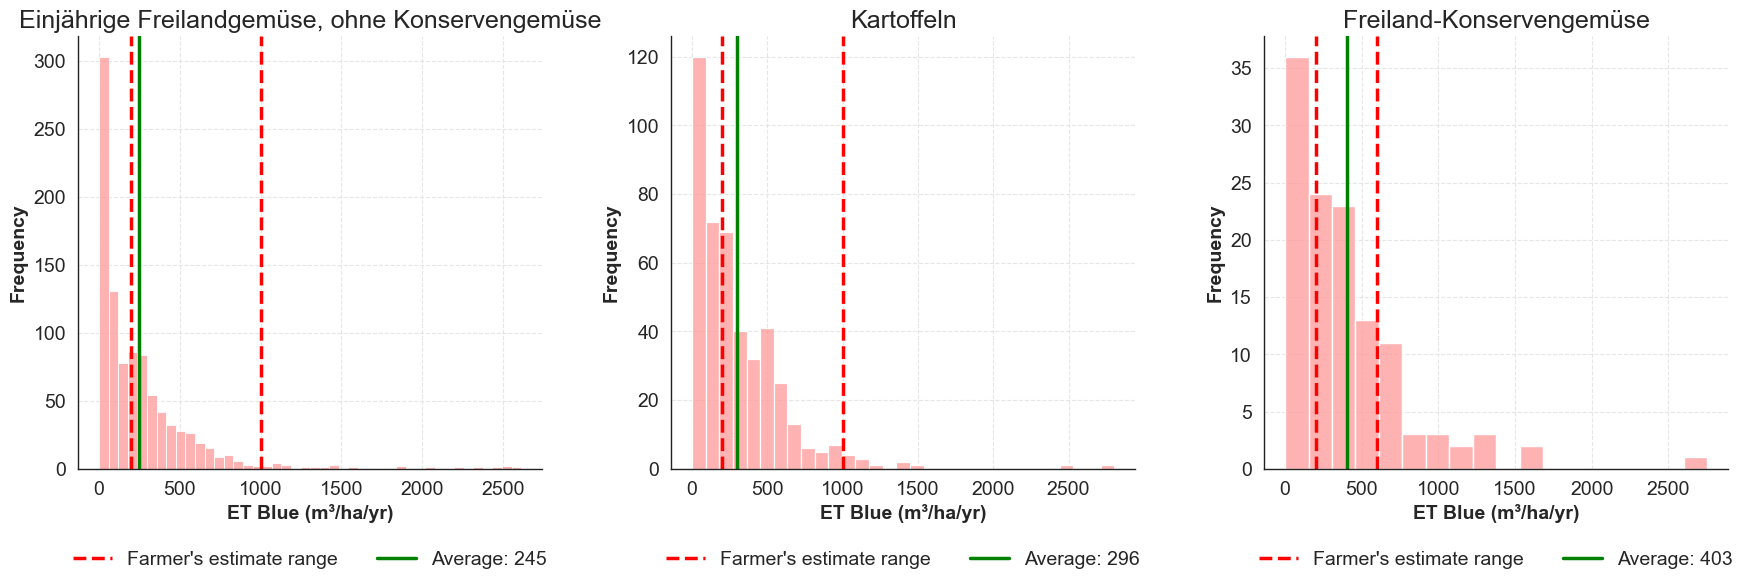

In [17]:
for year in range(2018, 2023):
    ET_blue_per_field = ee.FeatureCollection(
        f"projects/thurgau-irrigation/assets/Thurgau/ET_blue_m3_ha_yr_per_field_2018-2022/ET_blue_m3_ha_yr_per_field_{year}"
    )

    ET_blue_per_field_2018_df = geemap.ee_to_df(ET_blue_per_field)
    ET_blue_per_field_2018_df = ET_blue_per_field_2018_df[["ET_blue_m3_ha_yr", "nutzung"]]

    ET_blue_per_field_2018_df["ET_blue_m3_ha_yr"] = ET_blue_per_field_2018_df["ET_blue_m3_ha_yr"] / IRRIGATION_EFFICIENCY

    # Filter the DataFrame
    filtered_df = filter_dataframe(ET_blue_per_field_2018_df, list(irrigation_estimate.keys()))

    # Create the plot
    plot_histogram_comparison(filtered_df, irrigation_estimate, output_destination=f"/Users/cooper/Desktop/Hydrosolutions/ETblue-estimation /images/ET_blue_validation/ET_blue_histogram_comparison_{year}.png")

In [18]:
ET_blue_per_field = ee.FeatureCollection(
    "projects/thurgau-irrigation/assets/Thurgau/ET_blue_m3_ha_yr_per_field_2018-2022/ET_blue_m3_ha_yr_per_field_2018"
)

ET_blue_per_field.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[8.919914368911005, 47.39969125396386],
    [8.920222062801171, 47.399628855302325],
    [8.920253332811129, 47.399682370374336],
    [8.919954531136788, 47.399762601776615],
    [8.919914368911005, 47.39969125396386]]]},
 'id': '000000000000000015d5',
 'properties': {'Area': 177.108,
  'ET_blue_m3_ha_yr': 202,
  'beitragsbe': 1,
  'bewirtsc_1': 'b333c25a-455f-44fe-b80c-add79280df13',
  'bewirtscha': 100,
  'datum_bis': '2019/12/12 00:00:00.000',
  'datum_von': '2018/12/12 00:00:00.000',
  'einzelkult': 0,
  'hid': 120910,
  'ist_aggreg': 0,
  'ist_defini': 1,
  'ist_geomet': 0,
  'ist_ueberl': 0,
  'lnf_code': '721',
  'lq_bemerku': '',
  'nhg': 0,
  'nutzung': 'Mehrjährige gärtnerische Freilandkulturen (nicht im Gewächshaus)',
  'nutzung_im': 1,
  'nutzungsar': '16a302f0-6ff5-11e4-8bd7-2c4138b9e4d5',
  'nutzungsid': 'TG.KUL.910752',
  'objectid': 165244,
  'schnittzei': None,
  'status_tid': '259d27a8-2431-102f-b

In [22]:
Map = geemap.Map()

Map.addLayer(ET_blue_per_field.get("ET_blue_m3_ha_yr"), {}, "ET_blue_m3_ha_yr_per_field_2018")
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…